# Swin-Tiny - Clasificación de imágenes (Transfer Learning)
Dataset: SIMPD V1 (20 clases). Fine-tuning completo con transfer learning. Splits en `dataset_split/train`, `dataset_split/val`, `dataset_split/test`.

## 1. Imports y configuración de logging
Logging solo a consola; se fijan métricas/figuras en disco. Se intenta usar 90% de VRAM en CUDA.

In [1]:
import os
import time
from pathlib import Path
import random
import logging
from datetime import datetime

import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import timm
from timm.data import resolve_model_data_config, create_transform

import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de logging (solo consola)
logger = logging.getLogger("swin_logger")
logger.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
if logger.hasHandlers():
    logger.handlers.clear()
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    try:
        torch.cuda.set_per_process_memory_fraction(0.9, device=device)
        logger.info("CUDA configurado para usar hasta el 90% de la VRAM disponible.")
    except Exception as e:
        logger.warning(f"No se pudo fijar fracción de memoria CUDA: {e}")
logger.info(f"Dispositivo detectado: {device}")

c:\Users\chori\anaconda3\envs\EXAMEN\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-25 00:28:01,771 - WARNING - No se pudo fijar fracción de memoria CUDA: Expected a torch.device with a specified index or an integer, but got:cuda
2025-11-25 00:28:01,787 - INFO - Dispositivo detectado: cuda


## 2. Configuración global y semillas
Rutas, hiperparámetros y semillas. Ajusta `DATA_ROOT` si cambias la ubicación del split.

In [2]:
DATA_ROOT = Path("dataset_split")  # ajusta si tu carpeta difiere
TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR = DATA_ROOT / "val"
TEST_DIR = DATA_ROOT / "test"
CHECKPOINT_DIR = Path("checkpoints")
RESULTS_DIR = Path("results")
LOG_DIR = Path("logs")
for d in [CHECKPOINT_DIR, RESULTS_DIR, LOG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

NUM_CLASSES = 20  # ajustable (>=15)
BASE_BATCH_SIZE = 32
CURRENT_BS = int(os.getenv("BATCH_SIZE", BASE_BATCH_SIZE))
NUM_EPOCHS = 50
LR_FINE_TUNE = 1e-4
WEIGHT_DECAY = 0.05
PATIENCE_EARLY_STOP = 10
NUM_WORKERS = 0
PIN_MEMORY = True
SEED = 42


def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
    logger.info(f"Semilla establecida en {seed}")


set_seed(SEED)
logger.info("Configuración global lista. Se asume que los splits ya existen en carpetas.")

2025-11-25 00:28:01,819 - INFO - Semilla establecida en 42
2025-11-25 00:28:01,819 - INFO - Configuración global lista. Se asume que los splits ya existen en carpetas.


## 3. Carga de splits existentes
Se leen las carpetas `train/`, `val/`, `test` con subdirectorios por clase y se construyen DataFrames.

In [3]:
IMAGE_EXTENSIONS = {"jpg", "jpeg", "png", "bmp", "tif", "tiff"}


def gather_label_names(*split_dirs: Path):
    labels = set()
    for split_dir in split_dirs:
        if split_dir.exists():
            for item in split_dir.iterdir():
                if item.is_dir():
                    labels.add(item.name)
    return sorted(labels)


def build_split_df(split_dir: Path, label_to_idx: dict) -> pd.DataFrame:
    records = []
    for class_dir in split_dir.iterdir():
        if not class_dir.is_dir():
            continue
        label_name = class_dir.name
        for file in class_dir.rglob("*"):
            if file.is_file() and file.suffix.lower().lstrip(".") in IMAGE_EXTENSIONS:
                records.append(
                    {
                        "filepath": str(file.resolve()),
                        "label_idx": label_to_idx[label_name],
                        "label_name": label_name,
                    }
                )
    return pd.DataFrame(records)


LABEL_NAMES = gather_label_names(TRAIN_DIR, VAL_DIR, TEST_DIR)
label_to_idx = {name: idx for idx, name in enumerate(LABEL_NAMES)}
train_df = build_split_df(TRAIN_DIR, label_to_idx)
val_df = build_split_df(VAL_DIR, label_to_idx)
test_df = build_split_df(TEST_DIR, label_to_idx)

logger.info(
    f"Total imágenes: {len(train_df) + len(val_df) + len(test_df)} | "
    f"Clases: {len(LABEL_NAMES)} | Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}"
)

2025-11-25 00:28:03,148 - INFO - Total imágenes: 2513 | Clases: 20 | Train: 1751 | Val: 367 | Test: 395


## 4. Dataset personalizado y DataLoaders
Batch size configurable vía env `BATCH_SIZE`. Transforms específicos más augmentations ligeras.

In [4]:
class ImageCSVDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["filepath"]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = int(row["label_idx"])
        return img, label


def create_dataloaders(train_df, val_df, test_df, train_transform, eval_transform, batch_size):
    train_ds = ImageCSVDataset(train_df, transform=train_transform)
    val_ds = ImageCSVDataset(val_df, transform=eval_transform)
    test_ds = ImageCSVDataset(test_df, transform=eval_transform)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )
    logger.info(f"Batches -> Train: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")
    return train_loader, val_loader, test_loader

## 5. Definición del modelo (Swin-Tiny) y transforms con augmentations ligeras
Se usa auto-augment y Random Erasing suave.

In [5]:
MODEL_NAME = "swin_tiny_patch4_window7_224"
logger.info(f"Cargando modelo {MODEL_NAME}")
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES)
if hasattr(model, "set_grad_checkpointing"):
    model.set_grad_checkpointing(True)
model.to(device)

data_config = resolve_model_data_config(model)
train_transform = create_transform(
    **data_config,
    is_training=True,
    auto_augment="rand-m9-mstd0.5-inc1",
    re_prob=0.2,
    re_mode="pixel",
    re_count=1,
)
eval_transform = create_transform(**data_config, is_training=False)

total_params = sum(p.numel() for p in model.parameters()) / 1e6
logger.info(f"Parámetros totales: {total_params:.2f}M")

train_loader, val_loader, test_loader = create_dataloaders(train_df, val_df, test_df, train_transform, eval_transform, CURRENT_BS)

2025-11-25 00:28:03,187 - INFO - Cargando modelo swin_tiny_patch4_window7_224
2025-11-25 00:28:04,353 - INFO - Parámetros totales: 27.53M
2025-11-25 00:28:04,355 - INFO - Batches -> Train: 55 | Val: 12 | Test: 13


In [6]:
# Helper para reconstruir dataloaders al ajustar batch_size por OOM
def rebuild_loaders(new_batch_size: int):
    global CURRENT_BS, train_loader, val_loader, test_loader
    CURRENT_BS = new_batch_size
    train_loader, val_loader, test_loader = create_dataloaders(
        train_df, val_df, test_df, train_transform, eval_transform, CURRENT_BS
    )
    logger.info(f"Dataloaders reconstruidos con batch_size={CURRENT_BS}")

logger.info(f"Batch size inicial: {CURRENT_BS}")

2025-11-25 00:28:04,370 - INFO - Batch size inicial: 32


## 6. Funciones auxiliares (accuracy, EarlyStopping, loops con AMP y cronómetro por epoch)

In [7]:
def accuracy_from_logits(logits, labels):
    preds = logits.argmax(dim=1)
    correct = (preds == labels).sum().item()
    return correct, len(labels)


class EarlyStopping:
    def __init__(self, patience=10, mode="max"):
        self.patience = patience
        self.mode = mode
        self.best = -np.inf if mode == "max" else np.inf
        self.counter = 0
        self.should_stop = False

    def step(self, metric):
        improved = (metric > self.best) if self.mode == "max" else (metric < self.best)
        if improved:
            self.best = metric
            self.counter = 0
            return True
        self.counter += 1
        if self.counter >= self.patience:
            self.should_stop = True
        return False


def train_one_epoch(model, loader, criterion, optimizer, scaler, epoch):
    model.train()
    running_loss = 0.0
    correct_total = 0
    samples_total = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with autocast(enabled=(device.type == "cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * labels.size(0)
        correct, total = accuracy_from_logits(outputs, labels)
        correct_total += correct
        samples_total += total
    epoch_loss = running_loss / samples_total
    epoch_acc = correct_total / samples_total
    logger.info(f"Train Epoch {epoch}: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}")
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, criterion, epoch, phase_desc="Val"):
    model.eval()
    running_loss = 0.0
    correct_total = 0
    samples_total = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * labels.size(0)
        correct, total = accuracy_from_logits(outputs, labels)
        correct_total += correct
        samples_total += total
    epoch_loss = running_loss / samples_total
    epoch_acc = correct_total / samples_total
    logger.info(f"{phase_desc} Epoch {epoch}: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}")
    return epoch_loss, epoch_acc

## 7. Entrenamiento - Fine-tuning completo
Cronometraje por epoch, AdamW + Cosine, early stopping por val_acc.

In [8]:
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()

optimizer = torch.optim.AdamW(model.parameters(), lr=LR_FINE_TUNE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
early_stopper = EarlyStopping(patience=PATIENCE_EARLY_STOP, mode="max")

history_records = []
best_val_acc = -np.inf
best_checkpoint_path = CHECKPOINT_DIR / "best_swin.pth"

logger.info("==== Iniciando Fine-tuning Swin-Tiny ====")
for epoch in range(1, NUM_EPOCHS + 1):
    while True:
        try:
            epoch_start = time.perf_counter()
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, epoch)
            val_loss, val_acc = evaluate(model, val_loader, criterion, epoch, phase_desc="Val")
            scheduler.step()
            epoch_time = time.perf_counter() - epoch_start
            logger.info(f"Tiempo epoch {epoch} (fine-tune): {epoch_time:.2f}s")

            history_records.append(
                {
                    "epoch": epoch,
                    "phase": "finetune",
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                    "epoch_time_sec": epoch_time,
                }
            )

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), best_checkpoint_path)
                logger.info(f"Nuevo mejor modelo con val_acc={val_acc:.4f}. Checkpoint guardado.")
            if early_stopper.step(val_acc):
                logger.info(f"Early stopping progresivo: paciencia reiniciada (val_acc mejoró a {val_acc:.4f}).")
            if early_stopper.should_stop:
                logger.info("Early stopping activado. Fin del entrenamiento.")
                break
            break
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                torch.cuda.empty_cache()
                new_bs = max(4, CURRENT_BS // 2)
                if new_bs == CURRENT_BS:
                    raise
                logger.warning(f"OOM en fine-tune epoch {epoch}. Reduciendo batch_size a {new_bs} y recreando dataloaders.")
                rebuild_loaders(new_bs)
            else:
                raise

history_df = pd.DataFrame(history_records)
history_csv = LOG_DIR / "swin_train_history.csv"
history_df.to_csv(history_csv, index=False)
logger.info(f"Histórico de entrenamiento guardado en {history_csv}")

C:\Users\chori\AppData\Local\Temp\ipykernel_7948\3291228428.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
2025-11-25 00:28:04,428 - INFO - ==== Iniciando Fine-tuning Swin-Tiny ====
C:\Users\chori\AppData\Local\Temp\ipykernel_7948\850714424.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
2025-11-25 00:30:39,083 - INFO - Train Epoch 1: loss=1.1147, acc=0.6985
2025-11-25 00:31:21,663 - INFO - Val Epoch 1: loss=0.1489, acc=0.9482
2025-11-25 00:31:21,665 - INFO - Tiempo epoch 1 (fine-tune): 197.24s
2025-11-25 00:31:21,822 - INFO - Nuevo mejor modelo con val_acc=0.9482. Checkpoint guardado.
2025-11-25 00:31:21,823 - INFO - Early stopping progresivo: paciencia reiniciada (val_acc mejoró a 0.9482).
2025-11-25 00:33:54,975 - INFO - Train Epoch 2: loss=0.25

## 8. Curvas de entrenamiento (loss y accuracy)
Visualización de loss y accuracy para train y val.

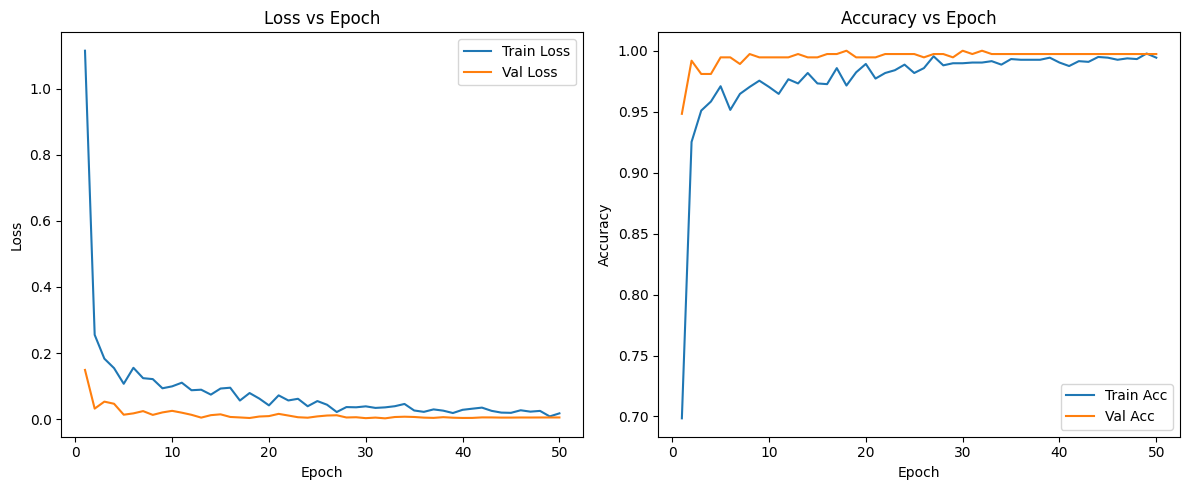

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df["epoch"], history_df["train_loss"], label="Train Loss")
plt.plot(history_df["epoch"], history_df["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df["epoch"], history_df["train_acc"], label="Train Acc")
plt.plot(history_df["epoch"], history_df["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()

## 9. Evaluación en test (accuracy, macro-F1, matriz de confusión)
Carga el mejor checkpoint, evalúa en test y guarda métricas y predicciones.

2025-11-25 03:10:21,325 - INFO - ==== Evaluación en Test ====
2025-11-25 03:10:57,365 - INFO - Test Accuracy: 0.9899 | Macro-F1: 0.9906
2025-11-25 03:10:57,380 - INFO - Classification report:
                         precision    recall  f1-score   support

       Abutilon Indicum     1.0000    1.0000    1.0000        26
Aloe barbadensis miller     0.9583    1.0000    0.9787        23
    Calotropis gigantea     1.0000    1.0000    1.0000        17
           Canna indica     1.0000    1.0000    1.0000        23
  Cissus quadrangularis     1.0000    1.0000    1.0000        21
          Curcuma longa     1.0000    1.0000    1.0000        17
      Eclipta prostrate     1.0000    1.0000    1.0000        32
   Eichhornia Crassipes     1.0000    0.9355    0.9667        31
  Hibiscus Rosasinensis     1.0000    0.9444    0.9714        18
         Ixora coccinea     0.9474    1.0000    0.9730        18
       Justica adhatoda     1.0000    1.0000    1.0000        15
       Murraya koenigii    

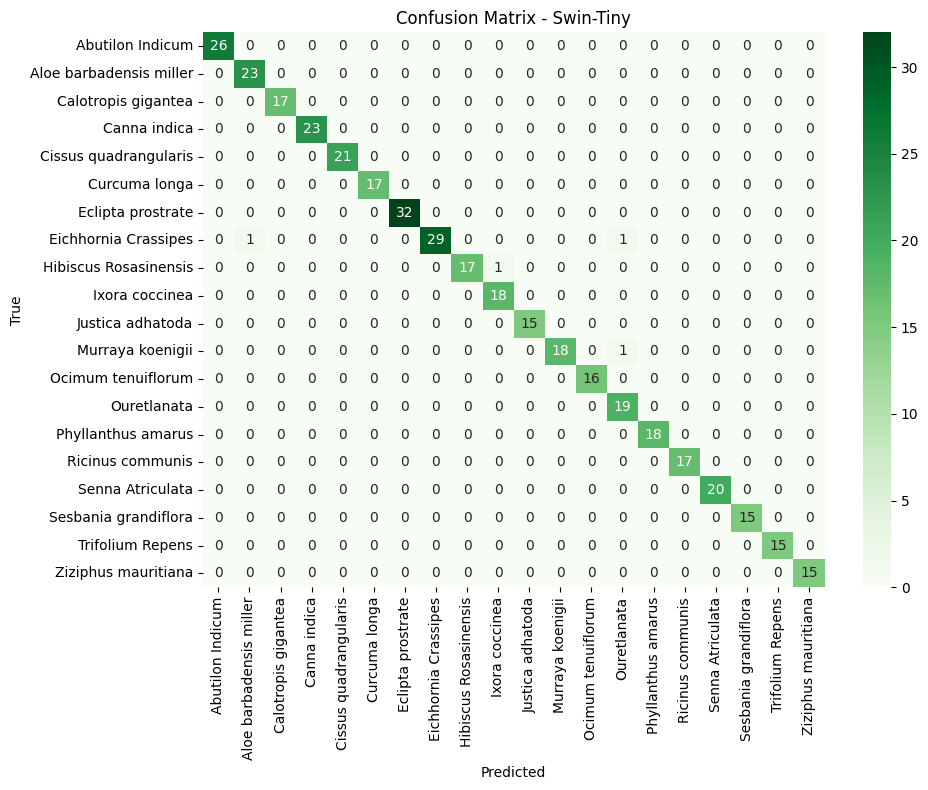

2025-11-25 03:10:58,651 - INFO - Matriz de confusión guardada en results\confmat_swin.png
2025-11-25 03:10:58,666 - INFO - Predicciones guardadas en results\preds_swin.csv
2025-11-25 03:10:58,668 - INFO - Métricas guardadas en results\metrics_swin.csv


In [10]:
logger.info("==== Evaluación en Test ====")
model.load_state_dict(torch.load(best_checkpoint_path, map_location=device))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average="macro")
logger.info(f"Test Accuracy: {test_acc:.4f} | Macro-F1: {test_f1:.4f}")

cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=LABEL_NAMES, digits=4)
logger.info("Classification report:\n" + report)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Swin-Tiny")
confmat_path = RESULTS_DIR / "confmat_swin.png"
plt.tight_layout()
plt.savefig(confmat_path, dpi=300)
plt.show()
logger.info(f"Matriz de confusión guardada en {confmat_path}")

preds_df = pd.DataFrame(
    {
        "filepath": test_df["filepath"].values[: len(all_labels)],
        "true_label": [LABEL_NAMES[i] for i in all_labels],
        "pred_label": [LABEL_NAMES[i] for i in all_preds],
    }
)
preds_df["correct"] = preds_df["true_label"] == preds_df["pred_label"]
preds_csv = RESULTS_DIR / "preds_swin.csv"
preds_df.to_csv(preds_csv, index=False)

metrics_df = pd.DataFrame([{"accuracy": test_acc, "macro_f1": test_f1, "timestamp": datetime.now().isoformat()}])
metrics_csv = RESULTS_DIR / "metrics_swin.csv"
metrics_df.to_csv(metrics_csv, index=False)

logger.info(f"Predicciones guardadas en {preds_csv}")
logger.info(f"Métricas guardadas en {metrics_csv}")